# Learn Shap

In [1]:
!pip install shap
!pip install xgboost

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

import shap
shap.initjs()

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Dataset

In [2]:
# import dataset
data = pd.read_csv('abalone.csv')
data = pd.DataFrame(data)
print(len(data))
data.head()

4177


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
x=data['Whole weight']
y=data['Rings']
print(y)

0       15
1        7
2        9
3       10
4        7
        ..
4172    11
4173    10
4174     9
4175    10
4176    12
Name: Rings, Length: 4177, dtype: int64


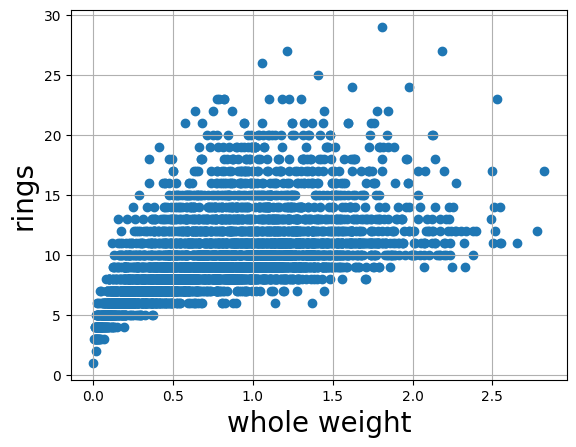

In [4]:
#Plot 1: whole weight
plt.scatter(x, y)
plt.ylabel('rings',size=20)
plt.xlabel('whole weight',size=20)
plt.grid(True)

Text(0.5, 0, 'Sex')

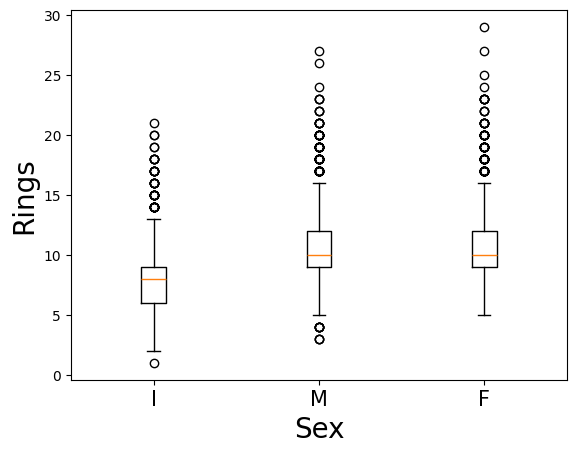

In [5]:
#Plot 2 sex
plt.boxplot(data[data.Sex=='I']['Rings'], positions=[1])
plt.boxplot(data[data.Sex=='M']['Rings'], positions=[2])
plt.boxplot(data[data.Sex=='F']['Rings'], positions=[3])

plt.xticks([1,2,3], ['I', 'M', 'F'], size=15)
plt.ylabel('Rings',size=20)
plt.xlabel('Sex',size=20)

<Axes: >

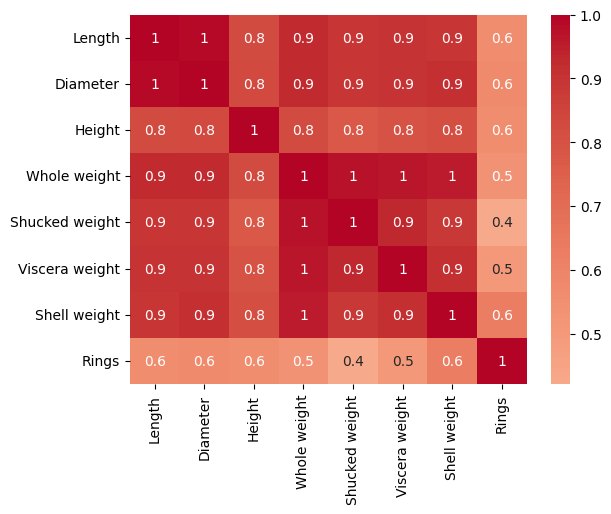

In [6]:
#Plot 3: Correlation heatmap
cont = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g')

# Feature Engineering

In [7]:
y = data['Rings']
X = data[['Sex', 'Length', 'Height', 'Shucked weight', 'Viscera weight', 'Shell weight']]

In [8]:
#Create dummy variables
X['Sex.M'] = [1 if s == 'M' else 0 for s in X['Sex']]
X['Sex.F'] = [1 if s == 'F' else 0 for s in X['Sex']]
X['Sex.I'] = [1 if s == 'I' else 0 for s in X['Sex']]
X = X.drop('Sex', axis=1)

X.head()

/tmp/ipykernel_96163/506883830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex.M'] = [1 if s == 'M' else 0 for s in X['Sex']]
/tmp/ipykernel_96163/506883830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex.F'] = [1 if s == 'F' else 0 for s in X['Sex']]


,Length,Height,Shucked weight,Viscera weight,Shell weight,Sex.M,Sex.F,Sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


# Modelling

In [9]:
#Train Model
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Text(0.5, 0, 'Actual')

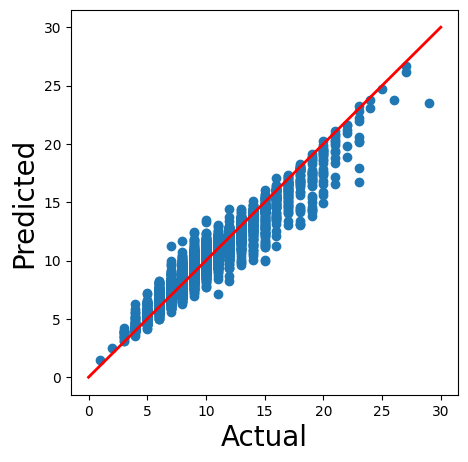

In [10]:
#Get Predictions
y_pred = model.predict(X)

#Model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y, y_pred)
plt.plot([0, 30],
         [0, 30],
         color='r',
         linestyle='-',
         linewidth=2)

plt.ylabel('Predicted', size=20)
plt.xlabel('Actual', size=20)

# 1) Standard SHAP Values

In [11]:
#Get SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

#shap_values = explainer(X[0:100])

In [12]:
np.shape(shap_values.values)

(4177, 8)

# Waterfall Plot

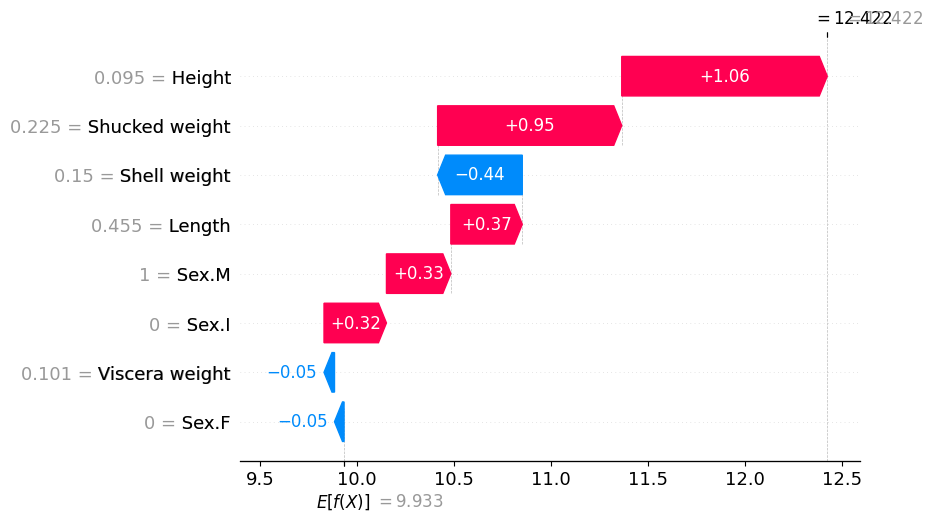

In [13]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

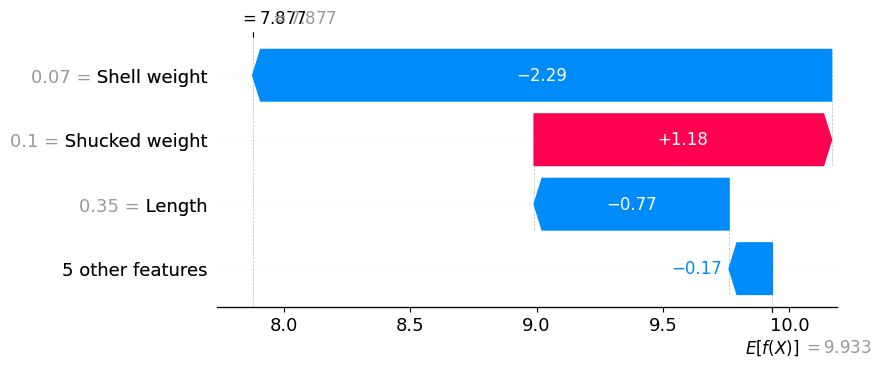

In [14]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[1], max_display=4)

# SHAP for binary target variables

In [15]:
#Binary target variable
y_bin = [1 if y_>10 else 0 for y_ in y]

In [16]:
#Train model
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

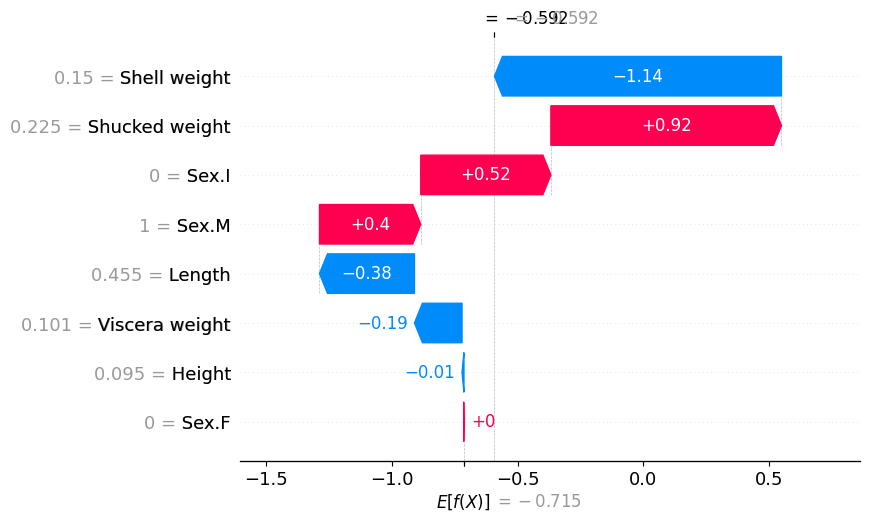

In [17]:
#Get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)

#Waterfall plot for first observation
shap.plots.waterfall(shap_values_bin[0])

# Force plot

In [18]:
shap.plots.force(shap_values[0])

# Stacked force Plot

In [19]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP

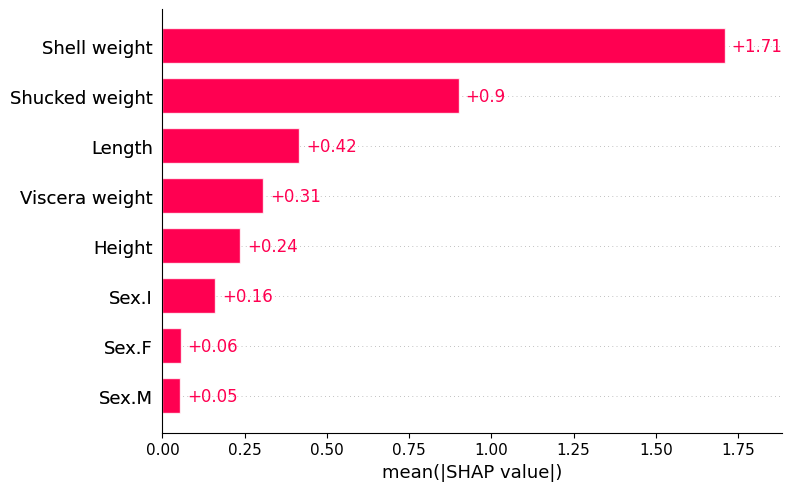

In [20]:
shap.plots.bar(shap_values)

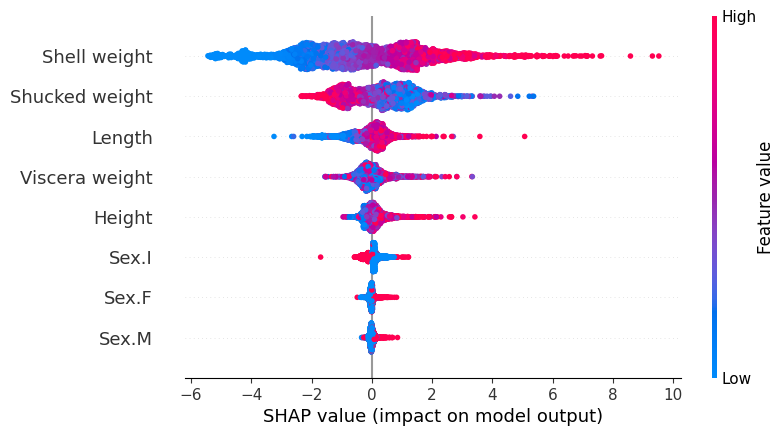

In [21]:
shap.plots.beeswarm(shap_values)

# Dependence Plots

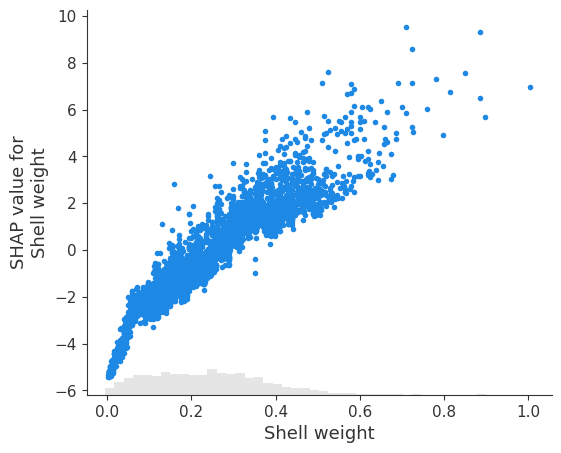

In [22]:
#Plot 1: shell weight
shap.plots.scatter(shap_values[:, 'Shell weight'])

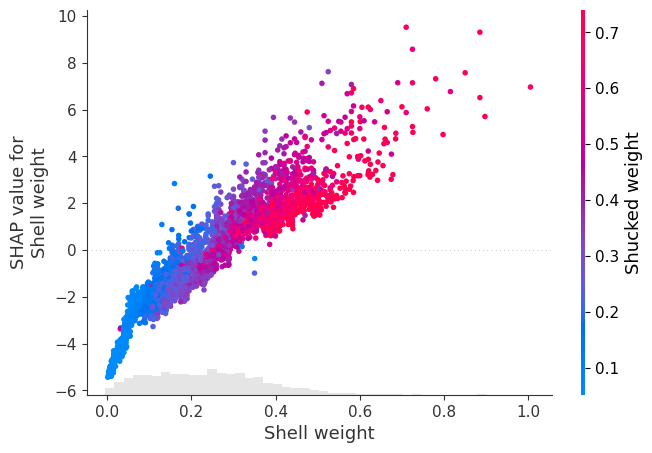

In [23]:
shap.plots.scatter(shap_values[:, "Shell weight"], color=shap_values[:, "Shucked weight"])

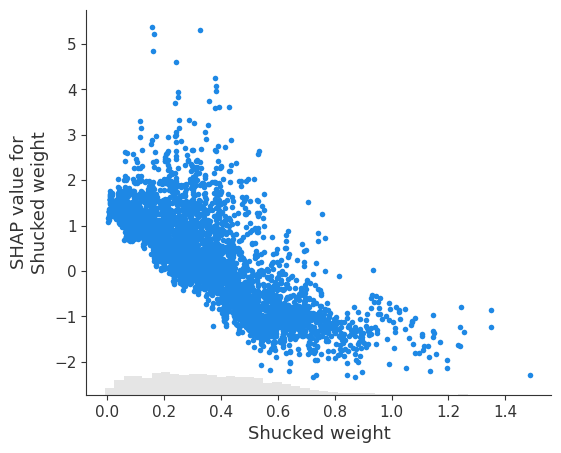

In [24]:
#Plot 2: Shucked weight
shap.plots.scatter(shap_values[:, 'Shucked weight'])

# 3) Custom Plots 

In [ ]:
#Output SHAP object
shap_values

.values =
array([[ 0.36806285,  1.0587054 ,  0.94834965, ...,  0.3316413 ,
        -0.04919233,  0.3216473 ],
       [-0.7708986 , -0.21779695,  1.176285  , ...,  0.05278974,
        -0.0395156 ,  0.49588168],
       [ 0.15351889, -0.02277692,  0.47050092, ...,  0.04105941,
         0.04848656,  0.12317639],
       ...,
       [ 0.14958209,  0.32025054, -1.4478747 , ...,  0.04284297,
         0.01527823,  0.02549139],
       [-0.04009023, -0.09120232, -0.919325  , ...,  0.05648781,
         0.05737196,  0.09682811],
       [ 0.61490464,  0.388789  , -0.55129325, ...,  0.05122245,
         0.00867648,  0.07278913]], dtype=float32)

.base_values =
array([9.93266, 9.93266, 9.93266, ..., 9.93266, 9.93266, 9.93266],
      dtype=float32)

.data =
array([[0.455 , 0.095 , 0.2245, ..., 1.    , 0.    , 0.    ],
       [0.35  , 0.09  , 0.0995, ..., 1.    , 0.    , 0.    ],
       [0.53  , 0.135 , 0.2565, ..., 0.    , 1.    , 0.    ],
       ...,
       [0.6   , 0.205 , 0.5255, ..., 1.    , 0.    